In [ ]:
# importing the necessities
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import FloatImage
from shapely.geometry import Point
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# Load the data
df = pd.read_csv('/content/drive/MyDrive/Naan Mudhalvan/updated_data.csv')

# Data overview
print("Dataset Shape:", df.shape)
print("First 5 rows of the dataset:")
print(df.head())

Dataset Shape: (321584, 8)
First 5 rows of the dataset:
         time  latitude  longitude  clay_content  sand_content  silt_content  \
0  2013-01-03    54.875      9.125           5.0          86.0           9.0   
1  2013-01-05    54.875      9.125           5.0          86.0           9.0   
2  2013-01-07    54.875      9.125           5.0          86.0           9.0   
3  2013-01-08    54.875      9.125           5.0          86.0           9.0   
4  2013-01-09    54.875      9.125           5.0          86.0           9.0   

     sm_aux  sm_tgt  
0  0.454120    0.53  
1  0.437102    0.44  
2  0.412978    0.42  
3  0.378734    0.55  
4  0.350740    0.46  


In [ ]:
# Descriptive statistics
print("Descriptive statistics of the dataset:")
print(df.describe())

Descriptive statistics of the dataset:
            latitude      longitude  clay_content   sand_content  \
count  321584.000000  321584.000000  321584.00000  321584.000000   
mean       50.840357       9.622973      20.88792      39.242963   
std         1.646484       3.789899       7.92268      21.846045   
min        48.125000       2.125000       4.00000       6.000000   
25%        49.375000       6.625000      13.00000      22.000000   
50%        50.875000       9.875000      22.00000      32.000000   
75%        52.125000      12.875000      27.00000      61.000000   
max        54.875000      15.875000      46.00000      86.000000   

        silt_content         sm_aux         sm_tgt  
count  321584.000000  321584.000000  321584.000000  
mean       39.894503       0.194109       0.411891  
std        15.229785       0.088552       0.110530  
min         8.000000      -0.038657       0.010000  
25%        25.000000       0.126050       0.350000  
50%        44.000000       0.1

In [ ]:
#Data Overview - Visualizing the data points in a map

# Create a base map centered around Germany
m = folium.Map(location=[51.1657, 10.4515], zoom_start=5, tiles="OpenStreetMap")

# Get unique locations
unique_locations_ = df[['latitude', 'longitude']].drop_duplicates()
print("There are", len(unique_locations_), "unique locations in the dataset.")

# Add unique locations to the map
for idx, row in unique_locations_.iterrows():
    folium.CircleMarker(location=(row['latitude'], row['longitude']), radius=1,color='red').add_to(m)

#display the map
m

There are 1166 unique locations in the dataset.


In [ ]:
#Data preprocessing - Remove the points outside Germany border

# Define a boundary for Germany
germany_boundary = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
germany_boundary = germany_boundary[germany_boundary.name == 'Germany']

# Create a GeoDataFrame containing the points
geometry = []

# Iterate over each row in the DataFrame
for index, row in unique_locations_.iterrows():
    # Extract longitude and latitude values from the current row
    longitude = row['longitude']
    latitude = row['latitude']

    # Create a Point object using the longitude and latitude
    point = Point(longitude, latitude)

    # Append the Point object to the list
    geometry.append(point)

points_gdf = gpd.GeoDataFrame(unique_locations_, geometry=geometry, crs=germany_boundary.crs)

# Perform spatial join to filter points within Germany boundary
points_within_germany = gpd.sjoin(points_gdf, germany_boundary, how="inner", op="within")

# Get the indices of points within Germany
indices_within_germany = points_within_germany.index

# Filter the original DataFrame based on the indices
df1 = df.loc[indices_within_germany]

# Display the filtered DataFrame
print("Filtered DataFrame with points only within Germany:")
print(df1.head())

<ipython-input-5-1f69c0243225>:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  germany_boundary = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


Filtered DataFrame with points only within Germany:
            time  latitude  longitude  clay_content  sand_content  \
476   2013-06-01    54.875      9.875          18.0          52.0   
478   2013-01-03    54.625      9.125          11.0          73.0   
657   2013-01-03    54.625      9.375           6.0          80.0   
901   2013-01-05    54.625      9.625          11.0          60.0   
1088  2013-04-15    54.625      9.875          14.0          56.0   

      silt_content    sm_aux  sm_tgt  
476           30.0  0.056876    0.51  
478           16.0  0.456073    0.53  
657           14.0  0.451374    0.56  
901           30.0  0.332698    0.52  
1088          30.0  0.123108    0.55  


In [ ]:
# Data overview of filtered dataset
print("Dataset Shape:", df1.shape)
print("First 5 rows of the dataset:")
print(df1.head())

Dataset Shape: (669, 8)
First 5 rows of the dataset:
            time  latitude  longitude  clay_content  sand_content  \
476   2013-06-01    54.875      9.875          18.0          52.0   
478   2013-01-03    54.625      9.125          11.0          73.0   
657   2013-01-03    54.625      9.375           6.0          80.0   
901   2013-01-05    54.625      9.625          11.0          60.0   
1088  2013-04-15    54.625      9.875          14.0          56.0   

      silt_content    sm_aux  sm_tgt  
476           30.0  0.056876    0.51  
478           16.0  0.456073    0.53  
657           14.0  0.451374    0.56  
901           30.0  0.332698    0.52  
1088          30.0  0.123108    0.55  


In [ ]:
#Check for missing values
print("Missing values in each column:")
print(df1.isnull().sum())

# Handle missing values by either removing or imputing them
df1 = df1.dropna()

Missing values in each column:
time            0
latitude        0
longitude       0
clay_content    0
sand_content    0
silt_content    0
sm_aux          0
sm_tgt          0
dtype: int64


In [ ]:
#Removal of duplicate records
df1.drop_duplicates()

,time,latitude,longitude,clay_content,sand_content,silt_content,sm_aux,sm_tgt
476,2013-06-01,54.875,9.875,18.0,52.0,30.0,0.056876,0.51
478,2013-01-03,54.625,9.125,11.0,73.0,16.0,0.456073,0.53
657,2013-01-03,54.625,9.375,6.0,80.0,14.0,0.451374,0.56
901,2013-01-05,54.625,9.625,11.0,60.0,30.0,0.332698,0.52
1088,2013-04-15,54.625,9.875,14.0,56.0,30.0,0.123108,0.55
...,...,...,...,...,...,...,...,...
318321,2013-01-02,48.125,11.875,19.0,34.0,47.0,0.247526,0.41
318629,2013-01-02,48.125,12.125,21.0,34.0,44.0,0.278902,0.54
318921,2013-01-02,48.125,12.375,22.0,26.0,52.0,0.262750,0.56
319184,2013-01-01,48.125,12.625,24.0,26.0,49.0,0.210752,0.48


In [ ]:
#Feature Engineering

# Remove the 'time' column from the DataFrame
df1.drop(columns=['time'], inplace=True)

#Averaging the satellite moisture values
df1['sm_avg'] = (df1['sm_aux']+df1['sm_tgt'])/2

df1

,latitude,longitude,clay_content,sand_content,silt_content,sm_aux,sm_tgt,sm_avg
476,54.875,9.875,18.0,52.0,30.0,0.056876,0.51,0.283438
478,54.625,9.125,11.0,73.0,16.0,0.456073,0.53,0.493037
657,54.625,9.375,6.0,80.0,14.0,0.451374,0.56,0.505687
901,54.625,9.625,11.0,60.0,30.0,0.332698,0.52,0.426349
1088,54.625,9.875,14.0,56.0,30.0,0.123108,0.55,0.336554
...,...,...,...,...,...,...,...,...
318321,48.125,11.875,19.0,34.0,47.0,0.247526,0.41,0.328763
318629,48.125,12.125,21.0,34.0,44.0,0.278902,0.54,0.409451
318921,48.125,12.375,22.0,26.0,52.0,0.262750,0.56,0.411375
319184,48.125,12.625,24.0,26.0,49.0,0.210752,0.48,0.345376


In [ ]:
# Detect outliers using z-scores
from scipy import stats

z_scores = np.abs(stats.zscore(df1))
threshold = 3
outliers = np.where(z_scores > threshold)

# Remove outliers from the DataFrame
df_no_outliers = df1[(z_scores < threshold).all(axis=1)]

print("Original DataFrame:")
print(df1)
print("\nDataFrame without outliers:")
print(df_no_outliers)

Original DataFrame:
        latitude  longitude  clay_content  sand_content  silt_content  \
476       54.875      9.875          18.0          52.0          30.0   
478       54.625      9.125          11.0          73.0          16.0   
657       54.625      9.375           6.0          80.0          14.0   
901       54.625      9.625          11.0          60.0          30.0   
1088      54.625      9.875          14.0          56.0          30.0   
...          ...        ...           ...           ...           ...   
318321    48.125     11.875          19.0          34.0          47.0   
318629    48.125     12.125          21.0          34.0          44.0   
318921    48.125     12.375          22.0          26.0          52.0   
319184    48.125     12.625          24.0          26.0          49.0   
319451    48.125     12.875          21.0          20.0          59.0   

          sm_aux  sm_tgt    sm_avg  
476     0.056876    0.51  0.283438  
478     0.456073    0.53  0.4

In [ ]:
#Preprocessing - Data Normalization

from sklearn.preprocessing import MinMaxScaler

# Define the columns you want to normalize
columns_to_normalize = ['clay_content', 'sand_content', 'silt_content', 'sm_aux', 'sm_tgt', 'sm_avg']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the selected columns
df_normalized = df_no_outliers.copy()
df_normalized[columns_to_normalize] = scaler.fit_transform(df_normalized[columns_to_normalize])

print(df_normalized)

        latitude  longitude  clay_content  sand_content  silt_content  \
476       54.875      9.875      0.400000      0.546667      0.372881   
478       54.625      9.125      0.200000      0.826667      0.135593   
657       54.625      9.375      0.057143      0.920000      0.101695   
901       54.625      9.625      0.200000      0.653333      0.372881   
1088      54.625      9.875      0.285714      0.600000      0.372881   
...          ...        ...           ...           ...           ...   
318321    48.125     11.875      0.428571      0.306667      0.661017   
318629    48.125     12.125      0.485714      0.306667      0.610169   
318921    48.125     12.375      0.514286      0.200000      0.745763   
319184    48.125     12.625      0.571429      0.200000      0.694915   
319451    48.125     12.875      0.485714      0.120000      0.864407   

          sm_aux   sm_tgt    sm_avg  
476     0.000000  0.71875  0.175406  
478     0.805553  0.78125  0.859142  
657     0

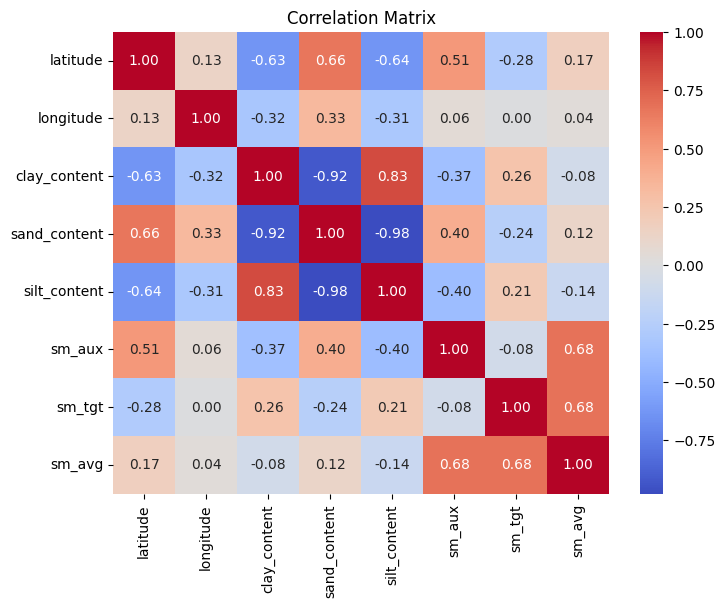

In [ ]:
# Compute the correlation matrix
correlation_matrix = df_normalized.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

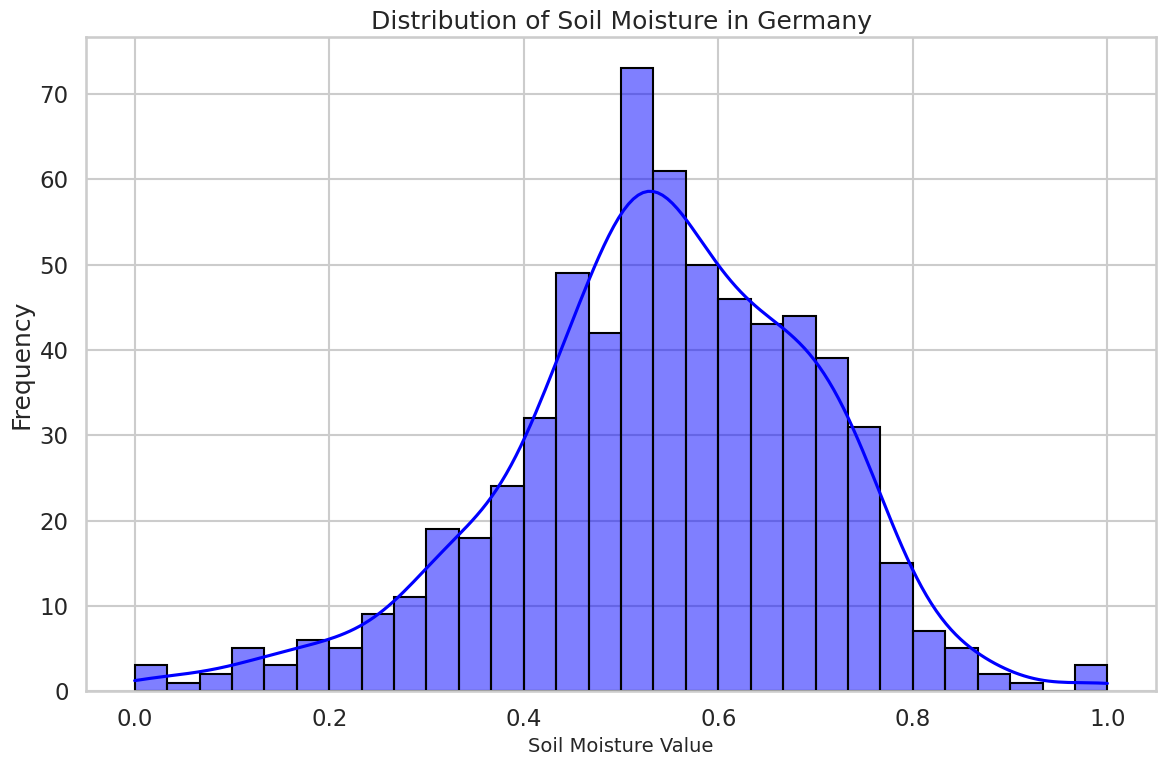

In [ ]:
#Style setting
sns.set_style("whitegrid")
sns.set_context("talk")

# Create the distribution plot
plt.figure(figsize=(12, 8))
sns.histplot(df_normalized['sm_avg'], bins=30, kde=True, color='blue', edgecolor='black')

plt.title("Distribution of Soil Moisture in Germany")
plt.xlabel("Soil Moisture Value", fontsize=14)
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

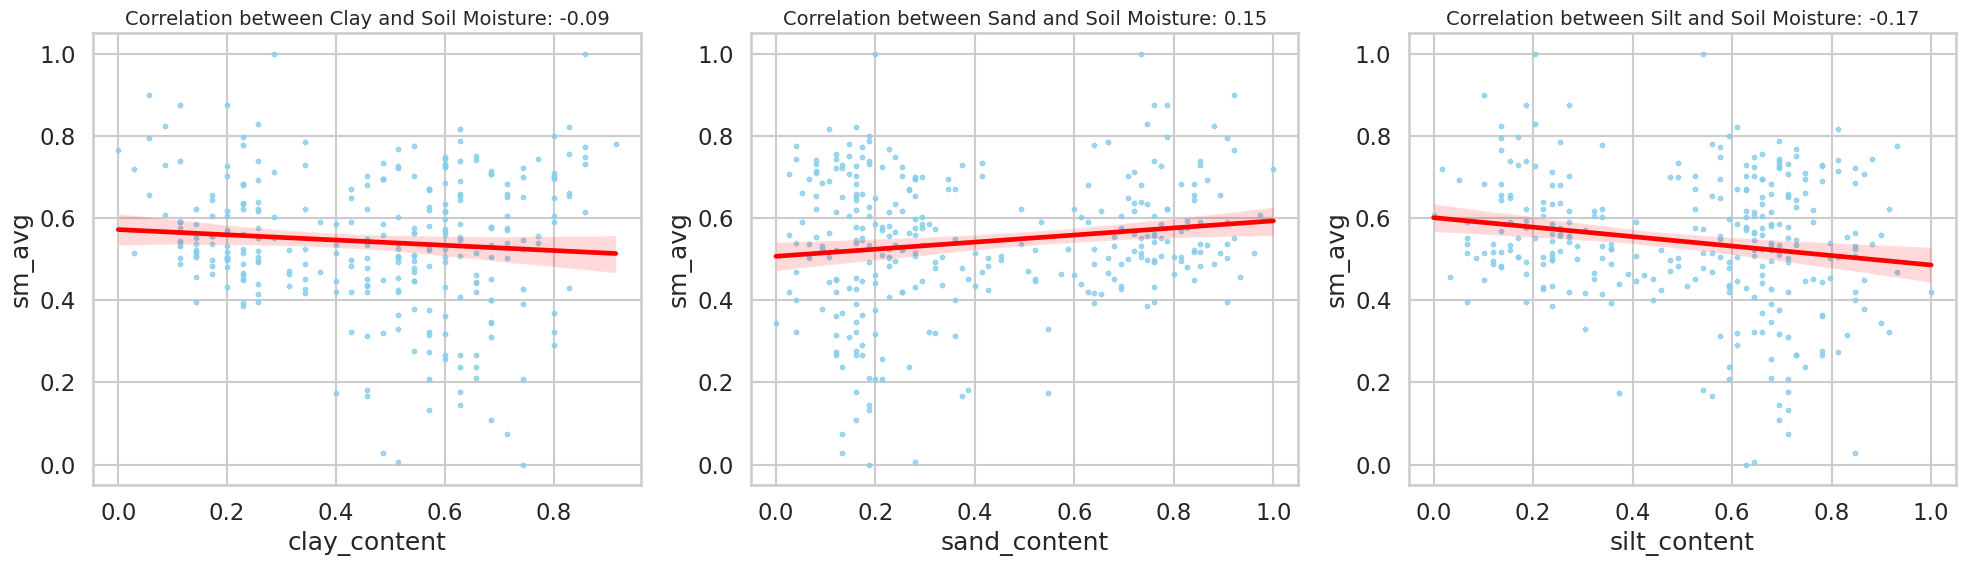

In [ ]:
# Randomly sample 300 data points from the dataframe
sample_df = df_normalized.sample(n=300, random_state=42)

# Initialize a figure with three subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

# List of soil components
components = ['clay_content', 'sand_content', 'silt_content']

# Plot scatter plots for each component
for i, component in enumerate(components):
    sns.regplot(x=component, y='sm_avg', data=sample_df, ax=axes[i], color='skyblue', scatter_kws={'s':10}, line_kws={'color':'red'})

    # Calculate correlation and annotate the plot with its value
    correlation = sample_df[component].corr(sample_df['sm_avg'])
    axes[i].set_title(f"Correlation between {component.split('_')[0].capitalize()} and Soil Moisture: {correlation:.2f}", fontsize=14)

# Adjust layout for better display
plt.tight_layout()
plt.show()

In [ ]:
#Feature Selection and Engineering

#Define Labels based on USDA Soil Taxonomy
def classify_soil(row):
    if row['clay_content'] < 0.20 and row['sand_content'] < 0.28 and row['silt_content'] >= 0.52:
        return 'silt'
    elif row['clay_content'] < 0.20 and row['sand_content'] >= 0.52:
        return 'sand'
    elif row['clay_content'] >= 0.20 and row['sand_content'] < 0.45 and row['silt_content'] >= 0.40:
        return 'sandy clay'
    elif row['clay_content'] < 0.7 and row['sand_content'] < 0.15 and row['silt_content'] < 0.52:
        return 'sandy loam'
    elif row['clay_content'] >= 0.7 and row['sand_content'] < 0.15 and row['silt_content'] < 0.52:
        return 'loamy sand'
    elif row['clay_content'] >= 0.7 and row['clay_content'] < 0.20 and row['sand_content'] >= 0.15 and row['sand_content'] < 0.28 and row['silt_content'] >= 0.52:
        return 'silt loam'
    elif row['clay_content'] < 0.7 and row['sand_content'] >= 0.15 and row['sand_content'] < 0.28 and row['silt_content'] < 0.52:
        return 'sandy clay loam'
    elif row['clay_content'] >= 0.7 and row['clay_content'] < 0.20 and row['sand_content'] < 0.15 and row['silt_content'] >= 0.52:
        return 'silty clay loam'
    elif row['clay_content'] >= 0.7 and row['clay_content'] < 0.20 and row['sand_content'] >= 0.15 and row['sand_content'] < 0.28 and row['silt_content'] < 0.52:
        return 'sandy clay loam'
    elif row['clay_content'] >= 0.20 and row['sand_content'] < 0.15 and row['silt_content'] >= 0.52:
        return 'clay loam'
    elif row['clay_content'] >= 0.20 and row['sand_content'] >= 0.15 and row['sand_content'] < 0.28 and row['silt_content'] >= 0.52:
        return 'silty clay loam'
    elif row['clay_content'] >= 0.20 and row['sand_content'] >= 0.28 and row['silt_content'] >= 0.52:
        return 'silty clay'
    elif row['clay_content'] >= 0.20 and row['sand_content'] < 0.52 and row['silt_content'] < 0.52:
        return 'clay'

# Apply classification
df_normalized['soil_texture'] = df_normalized.apply(classify_soil, axis=1)

print(df_normalized)

        latitude  longitude  clay_content  sand_content  silt_content  \
476       54.875      9.875      0.400000      0.546667      0.372881   
478       54.625      9.125      0.200000      0.826667      0.135593   
657       54.625      9.375      0.057143      0.920000      0.101695   
901       54.625      9.625      0.200000      0.653333      0.372881   
1088      54.625      9.875      0.285714      0.600000      0.372881   
...          ...        ...           ...           ...           ...   
318321    48.125     11.875      0.428571      0.306667      0.661017   
318629    48.125     12.125      0.485714      0.306667      0.610169   
318921    48.125     12.375      0.514286      0.200000      0.745763   
319184    48.125     12.625      0.571429      0.200000      0.694915   
319451    48.125     12.875      0.485714      0.120000      0.864407   

          sm_aux   sm_tgt    sm_avg soil_texture  
476     0.000000  0.71875  0.175406         None  
478     0.805553  0.7

In [ ]:
from sklearn.preprocessing import LabelEncoder

data = df_normalized.copy()

data = data.dropna()

# Select features for training from the original dataframe
selected_features = ['silt_content', 'sand_content', 'clay_content', 'sm_avg']

X = data[selected_features]  # Features (all columns except the target)
y = data['soil_texture']  # Target column


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Encode the target variable
y_train_encoded = label_encoder.fit_transform(y_train)

# Initialize and train the RandomForestClassifier
forest = RandomForestClassifier(n_estimators=50, random_state=0)
forest.fit(X_train, y_train_encoded)

# Predict on the test set
y_pred_encoded = forest.predict(X_test)

# Decode the predicted labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)

In [ ]:
#Evaluation of Model

# Print accuracy on training and testing subsets
print('Accuracy on the training subset: {:.3f}'.format(forest.score(X_train, y_train_encoded)))
print('Accuracy on the testing subset: {:.3f}'.format(forest.score(X_test, y_pred_encoded)))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Classification report
class_report = classification_report(y_test, y_pred)
print('Classification Report:')
print(class_report)

Accuracy on the training subset: 1.000
Accuracy on the testing subset: 1.000
Confusion Matrix:
[[  2   0   0]
 [  0  25   0]
 [  0   0 128]]
Classification Report:
              precision    recall  f1-score   support

        clay       1.00      1.00      1.00         2
        sand       1.00      1.00      1.00        25
  sandy clay       1.00      1.00      1.00       128

    accuracy                           1.00       155
   macro avg       1.00      1.00      1.00       155
weighted avg       1.00      1.00      1.00       155



In [ ]:
#Comparison with SVM and Decision Trees

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Train SVM model
svm_model = SVC(kernel='linear', random_state=0)
svm_model.fit(X_train, y_train)

# Train Decision Trees model
dt_model = DecisionTreeClassifier(random_state=0)
dt_model.fit(X_train, y_train)

# Predictions
svm_pred = svm_model.predict(X_test)
dt_pred = dt_model.predict(X_test)

# Evaluate SVM model
svm_accuracy = accuracy_score(y_test, svm_pred)
svm_conf_matrix = confusion_matrix(y_test, svm_pred)
svm_report = classification_report(y_test, svm_pred)

# Evaluate Decision Trees model
dt_accuracy = accuracy_score(y_test, dt_pred)
dt_conf_matrix = confusion_matrix(y_test, dt_pred)
dt_report = classification_report(y_test, dt_pred)

# Print performance metrics
print("SVM Performance Metrics:")
print("Accuracy:", svm_accuracy)
print("Confusion Matrix:\n", svm_conf_matrix)
print("Report:\n", svm_report)

print("\nDecision Trees Performance Metrics:")
print("Accuracy:", dt_accuracy)
print("Confusion Matrix:\n", dt_conf_matrix)
print("Report:\n", dt_report)

SVM Performance Metrics:
Accuracy: 0.9870967741935484
Confusion Matrix:
 [[  0   0   2]
 [  0  25   0]
 [  0   0 128]]
Report:
               precision    recall  f1-score   support

        clay       0.00      0.00      0.00         2
        sand       1.00      1.00      1.00        25
  sandy clay       0.98      1.00      0.99       128

    accuracy                           0.99       155
   macro avg       0.66      0.67      0.66       155
weighted avg       0.97      0.99      0.98       155


Decision Trees Performance Metrics:
Accuracy: 0.9935483870967742
Confusion Matrix:
 [[  1   0   0   1]
 [  0  25   0   0]
 [  0   0 128   0]
 [  0   0   0   0]]
Report:
               precision    recall  f1-score   support

        clay       1.00      0.50      0.67         2
        sand       1.00      1.00      1.00        25
  sandy clay       1.00      1.00      1.00       128
  silty clay       0.00      0.00      0.00         0

    accuracy                           0.99     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [ ]:
# Define colors for each class
class_colors = {
    'sand': 'red',
    'loamy sand': 'pink',
    'sandy loam': 'orange',
    'silt loam': 'lightgreen',
    'sandy clay loam': 'peach',
    'silty clay loam': 'yellow',
    'silty clay': 'blue',
    'clay loam': 'violet',
    'sandy clay': 'cyan',
    'clay': 'darkgreen',
    'silt': 'darkblue'
    # Add more colors for additional classes if needed
}

# Get unique classes from the data
unique_classes = data['soil_texture'].unique()
# Create a map centered at the mean of latitude and longitude
m = folium.Map(location=[data['latitude'].mean(), data['longitude'].mean()], zoom_start=10)

# Add markers for each data point with color corresponding to its class
for index, row in data.iterrows():
    class_color = class_colors.get(row['soil_texture'], 'black')  # Default to black if class not found
    folium.CircleMarker(location=[row['latitude'], row['longitude']], color=class_color, radius =1, fill_color=class_color).add_to(m)

# Create legend only for existing points on the map
legend_html = """
     <div style="position: fixed;
                 bottom: 50px; left: 50px; width: 180px; height: auto;
                 border:2px solid grey; z-index:9999; font-size:14px;
                 background-color: rgba(255, 255, 255, 0.8);
                ">
     <p style="margin: 10px; color:black;"><strong>Legend</strong></p>
     """
for cls in unique_classes:
    class_color = class_colors.get(cls, 'black')  # Default to black if class not found
    legend_html += f'<p style="margin: 5px; color:{class_color};">{cls}</p>'
legend_html += """
      </div>
     """

m.get_root().html.add_child(folium.Element(legend_html))

# Display the map
m